# My SRGAN

## 프로젝트 1 : 직접 고른 이미지로 SRGAN 실험하기
### 프로젝트 1-1.
1. (적당히) 높은 해상도를 가진 이미지를 검색해서 한 장 고른 후 저장하고 불러옵니다.
2. 불러온 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 1/4로 줄입니다. cv2.resize()를 사용해 봅시다.
3. 줄인 저해상도 이미지를 입력으로 SRGAN을 이용해 고해상도 이미지를 생성합니다. 이전에 사용한 apply_srgan 함수를 사용하면 쉽습니다.
4. 2.의 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 다시 4배로 늘립니다. 마찬가지로 cv2.resize()를 사용해 봅시다.
5. 3개 이미지(4.의 Bicubic의 결과, 3.의 SRGAN의 결과, 1.의 원래 고해상도 이미지)를 나란히 시각화합니다. 각 이미지의 제목에 어떤 방법에 대한 결과인지 표시해 주세요. 이전 시각화에 사용했던 코드를 참고하면 어렵지 않습니다.
6. 선택한 이미지를 DIV2K 데이터셋에서 학습된 모델로 Super Resolution했을 때 어떠한 결과가 나왔으며, 왜 이러한 결과가 출력되었는지 설명해 봅시다. (정답은 없습니다)
### 프로젝트 1-2.

1. (적당히) 낮은 해상도를 가진 이미지를 검색해서 한 장 고른 후 저장하고 불러옵니다.
2. 불러온 이미지를 입력으로 SRGAN을 이용해 고해상도 이미지를 생성합니다. 이전에 사용한 apply_srgan 함수를 사용하면 쉽습니다.
3. 1.에서 불러온 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 다시 4배로 늘립니다. cv2.resize()를 사용해 봅시다.
4. 2개 이미지(3.의 Bicubic의 결과, 2.의 SRGAN의 결과)를 나란히 시각화합니다. 각 이미지의 제목에 어떤 방법에 대한 결과인지 표시해 주세요. 이전 시각화에 사용했던 코드를 참고하면 어렵지 않습니다.
5. 선택한 이미지를 DIV2K 데이터셋에서 학습된 모델로 Super Resolution했을 때 어떠한 결과가 나왔으며, 왜 이러한 결과가 출력되었는지 설명해 봅시다. (정답은 없습니다)

## 프로젝트 2 : SRGAN을 이용해 고해상도 gif 생성하기

# 1-1 SRGAN

SRCNN은 저해상도 이미지에 대해 interpolation하여 고해상도 이미지 크기로 맞춘 후 입력으로 사용했지만, SRGAN은 그러한 과정을 거치지 않습니다.

In [98]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow as tf

tf.__version__


# 데이터를 불러옵니다.
#train, valid = tfds.load(
#    "div2k/bicubic_x4", 
#    split=["train","validation"],
#    as_supervised=True
#)

file_path_image = os.getenv('HOME')+'/aiffel/IMG_2279.jpg'


# 시각화를 위해 한 개의 데이터만 선택합니다.
#for i, (lr, hr) in enumerate(valid):
#    if i == 6: break
hr_cat = cv2.imread(file_path_image)
print(type(hr_cat))
print(hr_cat.shape) # 이미지의 크기를 출력합니다.

<class 'numpy.ndarray'>
(1491, 1125, 3)


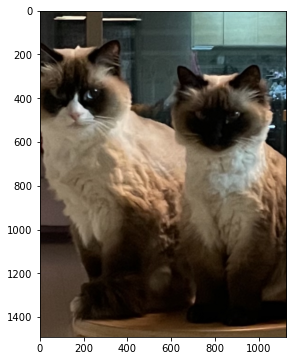

In [100]:
plt.figure(figsize=(8,6)) # fig사이즈 조절
hr_cat=cv2.cvtColor(hr_cat, cv2.COLOR_BGR2RGB) # BGR -> RGB 설정
plt.imshow(hr_cat)

<class 'numpy.ndarray'>
(372, 281, 3)


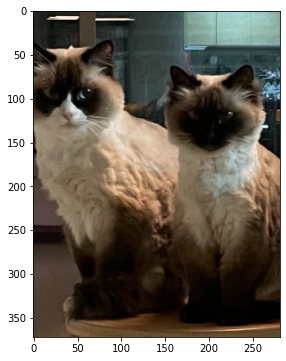

In [101]:
    
# 저해상도 이미지를 고해상도 이미지 크기로 bicubic interpolation 합니다.  
# hr, lr = np.array(hr), np.array(lr

#불러온 이미지에 bicubic interpolation 적용하여 가로 및 세로 픽셀 수 1/4
bicubic_hr = cv2.resize(
    hr_cat, 
    dsize=(hr_cat.shape[1]//4, hr_cat.shape[0]//4), # 고해상도 이미지 크기로 설정
    interpolation=cv2.INTER_CUBIC # bicubic 설정
)

print(type(bicubic_hr))
print(bicubic_hr.shape) # 이미지의 크기를 출력합니다.
plt.figure(figsize=(7,6)) # fig사이즈 조절
plt.imshow(bicubic_hr)

# 저해상도 및 고해상도 이미지를 시각화합니다.
#plt.figure(figsize=(20,10))
#plt.subplot(1,2,1); plt.imshow(bicubic_hr)
#plt.subplot(1,2,2); plt.imshow(hr)

#### 저해상도 이미지를 입력받아 고해상도 이미지를 생성하는 Generator를 구현
출처: https://arxiv.org/pdf/1609.04802.pd
그림 내의 k9n64s1라는 표기는 Convolutional layer 내의 hyperparameter 설정에 대한 정보이며, k는 kernel size, n은 사용 필터의 수, s는 stride를 나타냅니다. Tensorflow로 구현한다면 Conv2D(filters=64, kernel_size=9, strides=1, padding="same") 처럼 작성할 수 있습니다. 추가로 모든 stride가 1인 convolutional layer에는 패딩을 통해 출력의 크기를 계속 유지합니다.


In [86]:
from tensorflow.keras import Input, Model

# 그림의 파란색 블록을 정의합니다.
def gene_base_block(x):
    out = layers.Conv2D(64, 3, 1, "same")(x)
    out = layers.BatchNormalization()(out)
    out = layers.PReLU(shared_axes=[1,2])(out)
    out = layers.Conv2D(64, 3, 1, "same")(out)
    out = layers.BatchNormalization()(out)
    return layers.Add()([x, out])

# 그림의 뒤쪽 연두색 블록을 정의합니다.
def upsample_block(x):
    out = layers.Conv2D(256, 3, 1, "same")(x)
    # 그림의 PixelShuffler 라고 쓰여진 부분을 아래와 같이 구현합니다.
    out = layers.Lambda(lambda x: tf.nn.depth_to_space(x, 2))(out)
    return layers.PReLU(shared_axes=[1,2])(out)
    
# 전체 Generator를 정의합니다.
def get_generator(input_shape=(None, None, 3)):
    inputs = Input(input_shape)
    
    out = layers.Conv2D(64, 9, 1, "same")(inputs)
    out = residual = layers.PReLU(shared_axes=[1,2])(out)
    
    for _ in range(5):
        out = gene_base_block(out)
    
    out = layers.Conv2D(64, 3, 1, "same")(out)
    out = layers.BatchNormalization()(out)
    out = layers.Add()([residual, out])
    
    for _ in range(2):
        out = upsample_block(out)
        
    out = layers.Conv2D(3, 9, 1, "same", activation="tanh")(out)
    return Model(inputs, out)

print("✅")


✅


생성된 고해상도 이미지와 진짜 고해상도 이미지 사이에서 진짜를 판별해내는 Discriminator를 아래 그림에 따라 구현해 보겠습니다. 마찬가지로 Functional API를 사용

In [87]:
# 그림의 파란색 블록을 정의합니다.
def disc_base_block(x, n_filters=128):
    out = layers.Conv2D(n_filters, 3, 1, "same")(x)
    out = layers.BatchNormalization()(out)
    out = layers.LeakyReLU()(out)
    out = layers.Conv2D(n_filters, 3, 2, "same")(out)
    out = layers.BatchNormalization()(out)
    return layers.LeakyReLU()(out)

# 전체 Discriminator 정의합니다.
def get_discriminator(input_shape=(None, None, 3)):
    inputs = Input(input_shape)
    
    out = layers.Conv2D(64, 3, 1, "same")(inputs)
    out = layers.LeakyReLU()(out)
    out = layers.Conv2D(64, 3, 2, "same")(out)
    out = layers.BatchNormalization()(out)
    out = layers.LeakyReLU()(out)
    
    for n_filters in [128, 256, 512]:
        out = disc_base_block(out, n_filters)
    
    out = layers.Dense(1024)(out)
    out = layers.LeakyReLU()(out)
    out = layers.Dense(1, activation="sigmoid")(out)
    return Model(inputs, out)

print("✅")

✅


SRGAN은 VGG19를 이용해 content loss를 계산합니다. Tensorflow는 이미지넷 데이터로부터 잘 학습된 VGG19를 제공하고 있으며 이를 이용해 보겠습니다.

In [88]:
from tensorflow.python.keras import applications
def get_feature_extractor(input_shape=(None, None, 3)):
    vgg = applications.vgg19.VGG19(
        include_top=False, 
        weights="imagenet", 
        input_shape=input_shape
    )
    # 아래 vgg.layers[20]은 vgg 내의 마지막 convolutional layer 입니다.
    return Model(vgg.input, vgg.layers[20].output)

print("✅")


✅


In [89]:
### SRGAN 학습하기

In [90]:
from tensorflow.keras import losses, metrics, optimizers

generator = get_generator()
discriminator = get_discriminator()
vgg = get_feature_extractor()

# 사용할 loss function 및 optimizer 를 정의합니다.
bce = losses.BinaryCrossentropy(from_logits=False)
mse = losses.MeanSquaredError()
gene_opt = optimizers.Adam()
disc_opt = optimizers.Adam()

def get_gene_loss(fake_out):
    return bce(tf.ones_like(fake_out), fake_out)

def get_disc_loss(real_out, fake_out):
    return bce(tf.ones_like(real_out), real_out) + bce(tf.zeros_like(fake_out), fake_out)


@tf.function
def get_content_loss(hr_real, hr_fake):
    hr_real = applications.vgg19.preprocess_input(hr_real)
    hr_fake = applications.vgg19.preprocess_input(hr_fake)
    
    hr_real_feature = vgg(hr_real) / 12.75
    hr_fake_feature = vgg(hr_fake) / 12.75
    return mse(hr_real_feature, hr_fake_feature)


@tf.function
def step(lr, hr_real):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        hr_fake = generator(lr, training=True)
        
        real_out = discriminator(hr_real, training=True)
        fake_out = discriminator(hr_fake, training=True)
        
        perceptual_loss = get_content_loss(hr_real, hr_fake) + 1e-3 * get_gene_loss(fake_out)
        discriminator_loss = get_disc_loss(real_out, fake_out)
        
    gene_gradient = gene_tape.gradient(perceptual_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(discriminator_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return perceptual_loss, discriminator_loss


gene_losses = metrics.Mean()
disc_losses = metrics.Mean()

for epoch in range(1, 2):
    for i, (lr, hr) in enumerate(train):
        g_loss, d_loss = step(lr, hr)
        
        gene_losses.update_state(g_loss)
        disc_losses.update_state(d_loss)
        
        # 10회 반복마다 loss를 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \nGenerator_loss:{gene_losses.result():.4f} \nDiscriminator_loss:{disc_losses.result():.4f}", end="\n\n")
        
        if (i+1) == 200:
            break
            
    gene_losses.reset_states()
    disc_losses.reset_states()

EPOCH[1] - STEP[10] 
Generator_loss:0.0012 
Discriminator_loss:1.5833

EPOCH[1] - STEP[20] 
Generator_loss:0.0014 
Discriminator_loss:1.1521

EPOCH[1] - STEP[30] 
Generator_loss:0.0018 
Discriminator_loss:0.9481

EPOCH[1] - STEP[40] 
Generator_loss:0.0022 
Discriminator_loss:0.7762

EPOCH[1] - STEP[50] 
Generator_loss:0.0025 
Discriminator_loss:0.6337

EPOCH[1] - STEP[60] 
Generator_loss:0.0031 
Discriminator_loss:0.5299

EPOCH[1] - STEP[70] 
Generator_loss:0.0036 
Discriminator_loss:0.4556

EPOCH[1] - STEP[80] 
Generator_loss:0.0040 
Discriminator_loss:0.3996

EPOCH[1] - STEP[90] 
Generator_loss:0.0042 
Discriminator_loss:0.3560

EPOCH[1] - STEP[100] 
Generator_loss:0.0044 
Discriminator_loss:0.3209

EPOCH[1] - STEP[110] 
Generator_loss:0.0047 
Discriminator_loss:0.2919

EPOCH[1] - STEP[120] 
Generator_loss:0.0050 
Discriminator_loss:0.2677

EPOCH[1] - STEP[130] 
Generator_loss:0.0053 
Discriminator_loss:0.2473

EPOCH[1] - STEP[140] 
Generator_loss:0.0055 
Discriminator_loss:0.2297

E

### SRGAN 테스트하기

In [91]:
import tensorflow as tf
import os

model_file = os.getenv('HOME')+'/aiffel/super_resolution/srgan_G.h5'
srgan = tf.keras.models.load_model(model_file)

In [92]:
def apply_srgan(image):
    image = tf.cast(image[np.newaxis, ...], tf.float32)
    sr = srgan.predict(image)
    sr = tf.clip_by_value(sr, 0, 255)
    sr = tf.round(sr)
    sr = tf.cast(sr, tf.uint8)
    return np.array(sr)[0]

#train, valid = tfds.load(
#    "div2k/bicubic_x4", 
#    split=["train","validation"],
#    as_supervised=True
#)

#for i, (lr, hr) in enumerate(valid):
#    if i == 6: break

srgan_hr = apply_srgan(bicubic_hr)
print("✅")

✅


<class 'numpy.ndarray'>
(1488, 1124, 3)


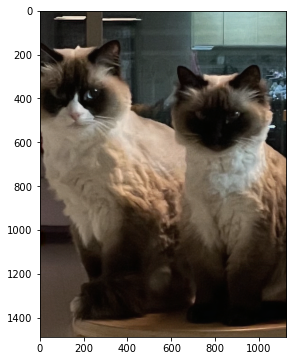

In [93]:

print(type(srgan_hr))
print(srgan_hr.shape) # 이미지의 크기를 출력합니다.
plt.figure(figsize=(7,6)) # fig사이즈 조절
plt.imshow(srgan_hr)

<class 'numpy.ndarray'>
(1488, 1124, 3)


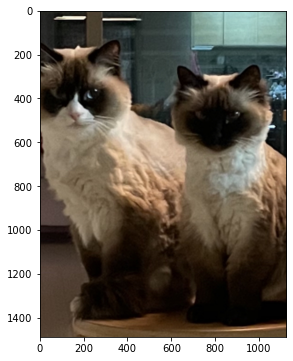

In [94]:
# 4배 다시 늘리기

bicubic_hr_extend = cv2.resize(
    bicubic_hr, 
    dsize=(bicubic_hr.shape[1]*4, bicubic_hr.shape[0]*4), # (가로 픽셀 수, 세로 픽셀 수)
    interpolation=cv2.INTER_CUBIC # bicubic interpolation 적용
)
print(type(bicubic_hr_extend))
print(bicubic_hr_extend.shape) # 이미지의 크기를 출력합니다.
plt.figure(figsize=(7,6)) # fig사이즈 조절
plt.imshow(bicubic_hr_extend)

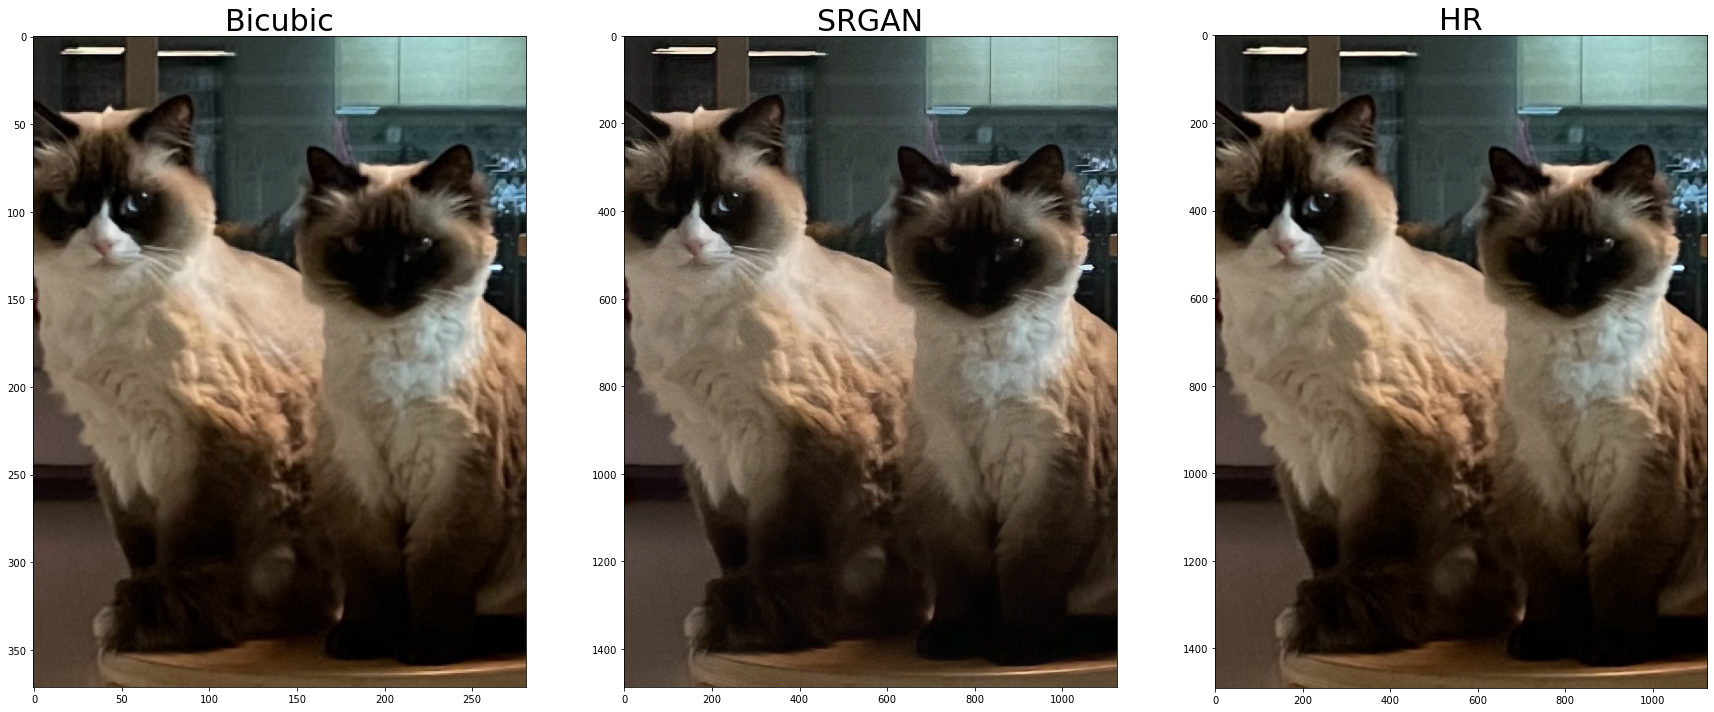

In [102]:
# 자세히 시각화 하기 위해 3개 영역을 잘라냅니다.
# 아래는 잘라낸 부분의 좌상단 좌표 3개 입니다.
image_list = [bicubic_hr, srgan_hr, hr_cat]

labels = ["Bicubic", "SRGAN", "HR"] 

plt.figure(figsize=(30,30))
for i in range(3):
    plt.subplot(1,3,i+1) 
    plt.imshow(image_list[i])
    plt.title(labels[i], fontsize=30)

선택한 이미지를 DIV2K 데이터셋에서 학습된 모델로 Super Resolution했을 때 어떠한 결과가 나왔으며, 왜 이러한 결과가 출력되었는지 설명해 봅시다. (정답은 없습니다)

 - Bicubic과 SRGAN을 비교해보면 Edge부분에 대해서 SRGAN이 더 선명하게 처리를 하는것같다. Bicubic은 일정한 패턴을 가지고 해상도를 늘려주는거라면 SRGAN은 각 픽셀의 영향성을 고려하여 해상도를 늘려주기 때문으로 판단된다. 

# 1-2 SRGAN

(1280, 913, 3)
(96, 96, 3)


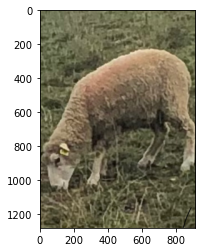

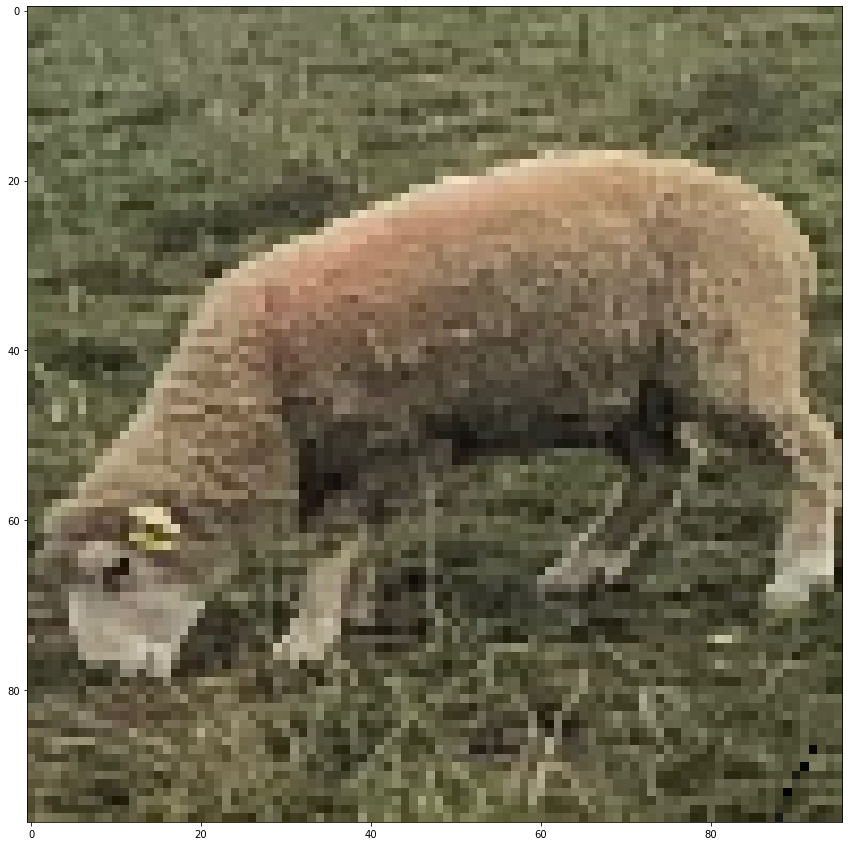

In [103]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

file_path_image = os.getenv('HOME')+'/aiffel/IMG_2280.jpg'


lr = cv2.imread(file_path_image)
print(lr.shape) # 이미지의 크기를 출력합니다.


lr=cv2.cvtColor(lr, cv2.COLOR_BGR2RGB) # BGR -> RGB 설정
plt.imshow(lr)
lr = cv2.resize(lr, dsize=(96,96)) # (가로 픽셀 수, 세로 픽셀 수)
print(lr.shape) # 이미지의 크기를 출력합니다.

plt.figure(figsize=(15,15)) # fig사이즈 조절
plt.imshow(lr)

## SRGAN

In [104]:
import tensorflow as tf
import os

model_file = os.getenv('HOME')+'/aiffel/super_resolution/srgan_G.h5'
srgan = tf.keras.models.load_model(model_file)


In [105]:
def apply_srgan(image):
    image = tf.cast(image[np.newaxis, ...], tf.float32)
    sr = srgan.predict(image)
    sr = tf.clip_by_value(sr, 0, 255)
    sr = tf.round(sr)
    sr = tf.cast(sr, tf.uint8)
    return np.array(sr)[0]

In [107]:
import numpy as np
srgan02_hr = apply_srgan(lr)
print("✅")

✅


<class 'numpy.ndarray'>
(384, 384, 3)


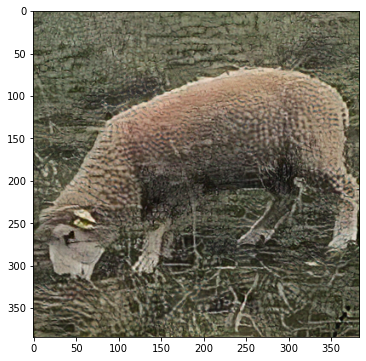

In [108]:
print(type(srgan02_hr))
print(srgan02_hr.shape) # 이미지의 크기를 출력합니다.
plt.figure(figsize=(7,6)) # fig사이즈 조절
plt.imshow(srgan02_hr)

### Bicubic

<class 'numpy.ndarray'>
(384, 384, 3)


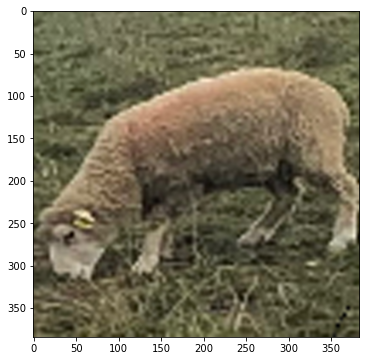

In [109]:
# lr 이미지를 작업하자. 4배 늘리기
bicubic_image = cv2.resize(
    lr, 
    dsize=(lr.shape[1]*4, lr.shape[0]*4), # (가로 픽셀 수, 세로 픽셀 수)
    interpolation=cv2.INTER_CUBIC # bicubic interpolation 적용
)
print(type(bicubic_image))
print(bicubic_image.shape) # 이미지의 크기를 출력합니다.
plt.figure(figsize=(7,6)) # fig사이즈 조절
plt.imshow(bicubic_image)

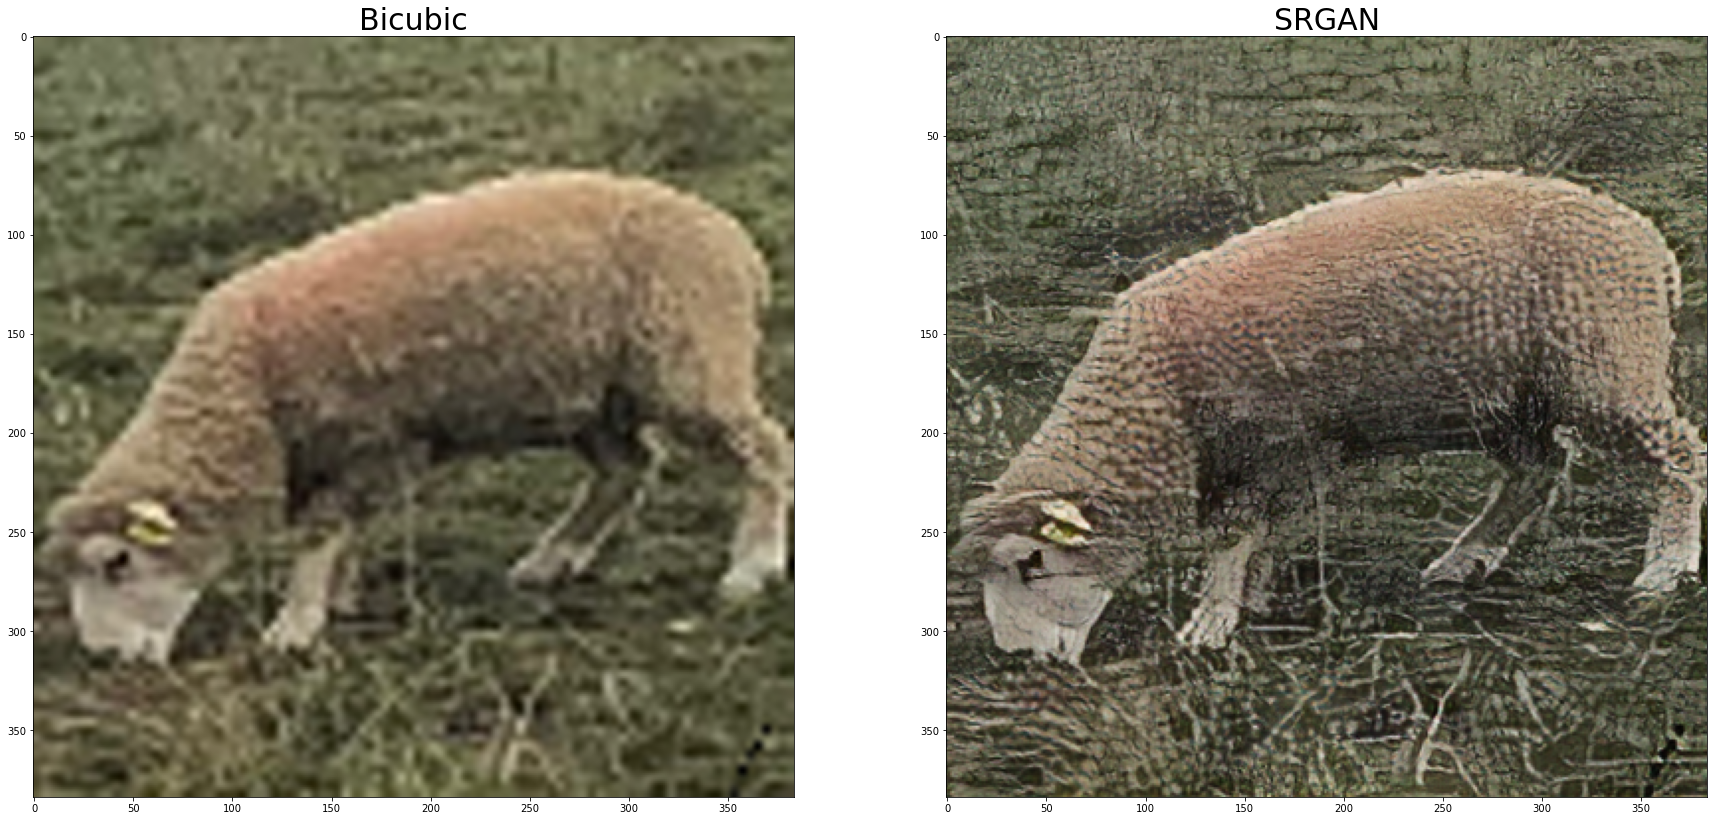

In [110]:
# 아래는 잘라낸 부분의 좌상단 좌표 3개 입니다.
image_list_1_2 = [bicubic_image, srgan02_hr]

labels = ["Bicubic", "SRGAN"] 

plt.figure(figsize=(30,30))
for i in range(2):
    plt.subplot(1,2,i+1) 
    plt.imshow(image_list_1_2[i])
    plt.title(labels[i], fontsize=30)

선택한 이미지를 DIV2K 데이터셋에서 학습된 모델로 Super Resolution했을 때 어떠한 결과가 나왔으며, 왜 이러한 결과가 출력되었는지 설명해 봅시다. 
 - SRGAN을 통해서 확연하게 super resolution이 된걸 확인할 수 있었다. 기존 DIV2K 데이터셋이 동물 위주로 많이 학습이 되었다고하여서 그런지 털에 대한 표현이 잘된것같고 앞서 얘기한것처럼 Edge부분에 대한 선명도가 더 좋은것같다. 